In [10]:
import pandas as pd
import numpy as np
import os

In [11]:
os.chdir('D:/Penn/Career/Citadel/2021datathon')
match = pd.read_csv('match_discrete_htwt_drop30.csv')
match['date']  = pd.to_datetime(match['date'])
df_clus = pd.read_csv('team_att_w_cluster.csv')
df_clus['date']  = pd.to_datetime(df_clus['date'])

In [12]:
match.shape

(17581, 201)

In [13]:
Nc = df_clus['cluster'].max() + 1
Nc

10

In [14]:
def get_meta(team_id, date):
    df = df_clus[df_clus['team_id'] == team_id]

    # return -1 if there is no record of the team's meta
    if df.shape[0] == 0:
        return -1

    clus = df.iloc[0, :]['cluster']
    for i in range(1, df.shape[0]):
        if df.iloc[i, :]['date'] < date:
            clus = df.iloc[i, :]['cluster']
        else:
            break
    
    return clus

In [15]:
# The following matrices register information only on the upper half - i.e. i >= j
goal_mat = np.zeros((Nc, Nc)) # goal_mat[i][j] is the net # of goals meta i scored against meta j. Could be positive or negative
match_mat = np.zeros((Nc, Nc)) # match_mat[i][j] is the total # of matches meta i played against meta j

for row in range(match.shape[0]):
    h_meta = get_meta(match['home_team_id'].loc[row], match['date'].loc[row])
    if h_meta < 0:
        continue
    a_meta = get_meta(match['away_team_id'].loc[row], match['date'].loc[row])
    if a_meta < 0:
        continue

    if h_meta < a_meta:
        match_mat[h_meta, a_meta] += 1
        goal_mat[h_meta, a_meta] += match['home_team_goal'].loc[row] - match['away_team_goal'].loc[row]
    else:
        match_mat[a_meta, h_meta] += 1
        goal_mat[a_meta, h_meta] += match['away_team_goal'].loc[row] - match['home_team_goal'].loc[row]

KeyboardInterrupt: 

In [7]:
print(match_mat)
print(goal_mat)

[[581. 542. 641. 112. 145. 492. 461. 369. 880. 111.]
 [  0. 426. 355. 200.  65. 688. 679. 214. 626.  89.]
 [  0.   0. 356. 241. 106. 475. 422. 263. 709. 153.]
 [  0.   0.   0.  73.  77. 224. 193. 141. 142.  60.]
 [  0.   0.   0.   0. 386.  87. 166.  63. 110.  14.]
 [  0.   0.   0.   0.   0. 323. 598. 364. 605. 116.]
 [  0.   0.   0.   0.   0.   0. 421. 247. 605.  40.]
 [  0.   0.   0.   0.   0.   0.   0. 206. 230. 132.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 408. 106.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 198.]]
[[-247.  -30. -389.  -62.  -10.   -2. -108.   67.  -97.  -14.]
 [   0.  -80. -212. -152.   -3. -130. -248.   -1. -160.  -48.]
 [   0.    0. -182.    5.   47.  174.  109.   87.  283.   94.]
 [   0.    0.    0.  -49.   38.  116.  120.   68.   70.    8.]
 [   0.    0.    0.    0. -217.   -2.  -55.   39.  -11.    9.]
 [   0.    0.    0.    0.    0. -155. -262.    5.  -78.    5.]
 [   0.    0.    0.    0.    0.    0. -156.  122.  -49.  -11.]
 [   0.    0.    0.    0.   

In [8]:
meta_mat = np.divide(goal_mat, match_mat, out = np.zeros_like(match_mat), where = match_mat != 0)
np.set_printoptions(precision = 3)
print(meta_mat)

[[-0.425 -0.055 -0.607 -0.554 -0.069 -0.004 -0.234  0.182 -0.11  -0.126]
 [ 0.    -0.188 -0.597 -0.76  -0.046 -0.189 -0.365 -0.005 -0.256 -0.539]
 [ 0.     0.    -0.511  0.021  0.443  0.366  0.258  0.331  0.399  0.614]
 [ 0.     0.     0.    -0.671  0.494  0.518  0.622  0.482  0.493  0.133]
 [ 0.     0.     0.     0.    -0.562 -0.023 -0.331  0.619 -0.1    0.643]
 [ 0.     0.     0.     0.     0.    -0.48  -0.438  0.014 -0.129  0.043]
 [ 0.     0.     0.     0.     0.     0.    -0.371  0.494 -0.081 -0.275]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.417 -0.196  0.341]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.348 -0.245]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.354]]


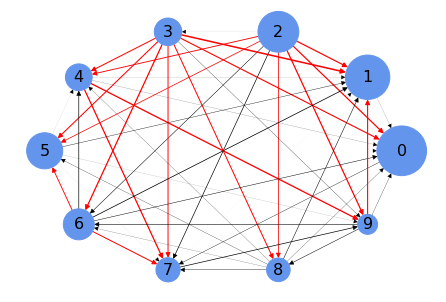

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

wt_fac = 2
nd_base = 300
nd_fac = 0.5

G = nx.DiGraph()
wt_thr = np.percentile(abs(meta_mat), 75)

for i in range(0, Nc):
    for j in range(i, Nc):
        color = 'red' if abs(meta_mat[i, j]) > wt_thr else 'black'
        if meta_mat[i, j] > 0:
            G.add_edge(i, j, weight = meta_mat[i, j] * wt_fac, color = color)
        else:
            G.add_edge(j, i, weight = -meta_mat[i, j] * wt_fac, color = color)

pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

nx.draw(G, pos, width = weights, with_labels = True, \
    node_size = np.array([sum(match_mat[i]) for i in range(Nc)]) * nd_fac + nd_base, \
    node_color='cornflowerblue', font_size = 16, edge_color = colors)
plt.show()